<a href="https://colab.research.google.com/github/EVA6-Group-15/cifar_explainbility/blob/master/notebooks/CIFAR10_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.89GB
Used: 536.20MB
Percentage: 6.3%


In [ ]:
! nvidia-smi

Mon Jul 12 09:10:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Module Imports

In [ ]:
!pip install -qq git+https://github.com/albumentations-team/albumentations

In [ ]:
!git clone -qq https://github.com/ikshana-ai/ikshana -b OneCycle ./temp
!cp -r ./temp/src/ikshana/ ./ikshana
!rm -r temp

In [ ]:
from ikshana.data.pytorch_data import GetData
from ikshana.data.transformations import * #HELPER, generate_compose
from ikshana.visualization import plot_inference, plotter

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import matplotlib.pyplot as plt

# Data

## Finding Data Stats

In [ ]:
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if use_cuda else "cpu")

LOADER_kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

In [ ]:
cifar = GetData('CIFAR10')

In [ ]:
train_data = cifar.build_data(train=True)
test_data = cifar.build_data(train=False)

In [ ]:
loader = DataLoader(
    train_data,
    batch_size=1000,
    num_workers=1,
    shuffle=False
)

mean, std = plotter.data_stats(loader)

Train Statistics
Image Shape:  torch.Size([3, 32, 32])
 - mean: tensor([0.4914, 0.4822, 0.4465])
 - std: tensor([0.2470, 0.2434, 0.2615])


## Creating Augmentations for Data

In [ ]:
import albumentations as A

In [ ]:
import cv2
transformations = {
    'Sequential': {
                    'PadIfNeeded': {'min_height': 40, 'min_width': 40, 'border_mode': cv2.BORDER_CONSTANT,
                                    'value': mean.tolist()},
                    'RandomCrop': {'height': 32, 'width': 32, 'p': 1},
                    'p': 1
                },
    'CoarseDropout': {'max_holes': 1, 'max_height':16, 'max_width':16, 'min_holes': 1, 
                      'min_height':16, 'min_width':16, 'fill_value': mean.tolist(), 
                      'mask_fill_value': None},
    'Rotate': {'limit': 5}
}

In [ ]:
train_trans = generate_compose(mean, std, **transformations) # Normalize and ToTensor by Default along with Transformations
test_trans = generate_compose(mean, std) # Normalize and ToTensor by Default. No other Transformations

In [ ]:
train_data = cifar.build_data(train_trans, train=True)
test_data = cifar.build_data(test_trans, train=False)
train_loader = cifar.build_loader(train_data, 512, **LOADER_kwargs)
test_loader = cifar.build_loader(test_data, 512, **LOADER_kwargs)

In [ ]:
classes = train_data.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Training Data

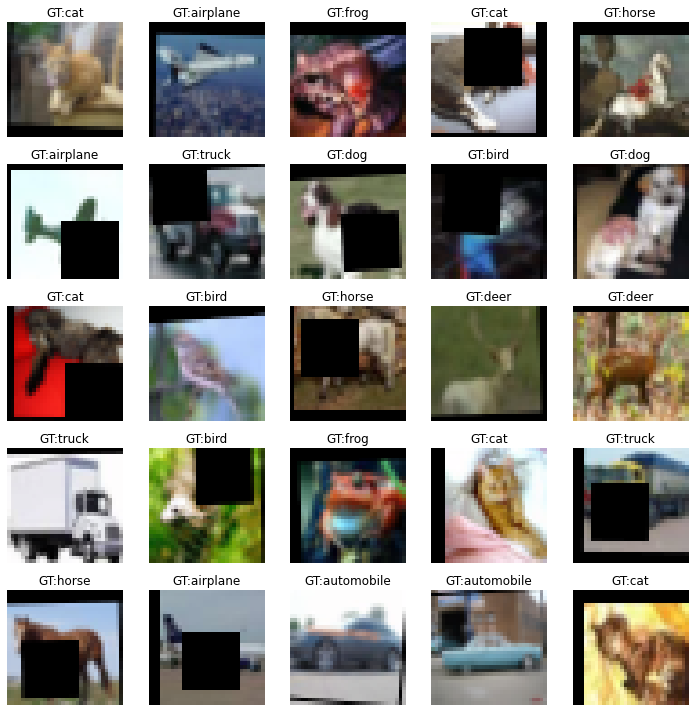

In [ ]:
from ikshana.visualization import plot_inference, plotter
plotter.plot_data_grid(train_loader, mean= mean, std= std, class_list=classes, ncol=5,nrow=5)

### Test Data

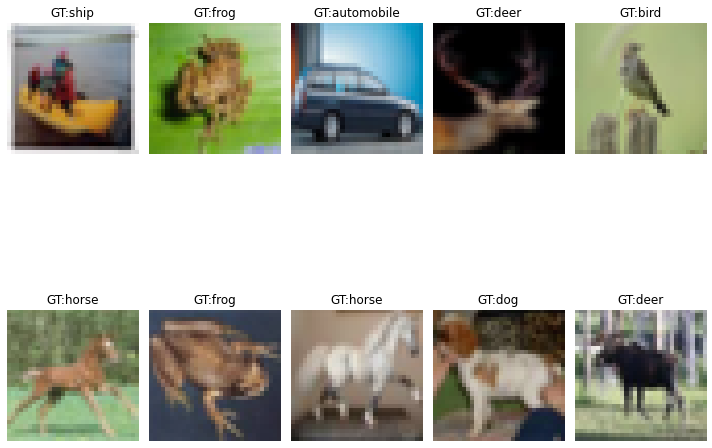

In [ ]:
plotter.plot_data_grid(test_loader, mean= mean, std= std, class_list=classes, ncol=5,nrow=2)

# Model

In [ ]:
from ikshana.models.ResNets.resnet import resnet18

In [ ]:
model = resnet18(norm=nn.LayerNorm, act=nn.ReLU, stride=[1,2,2,1]).to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
         GroupNorm-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
        BasicBlock-8           [-1, 64, 32, 32]               0
         GroupNorm-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
        GroupNorm-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
from ikshana.features.runner import run

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = resnet18(norm=nn.LayerNorm, act=nn.ReLU, stride=[1,2,2,1]).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, threshold=0.001, threshold_mode='rel')
ai = run.Run(model, train_loader, test_loader, 41, DEVICE, optimizer, scheduler)
ai(metrics = 'loss')

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1


loss=1.9409279823303223 batch_id=97: 100%|██████████| 98/98 [01:05<00:00,  1.49it/s]


TRAIN set: Average loss: 2.1057, Train Accuracy: 22.31% | TEST set: Average loss: 1.8780, Test Accuracy: 30.33%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 2
TRAIN set: Average loss: 1.8398, Train Accuracy: 31.96% | TEST set: Average loss: 1.8256, Test Accuracy: 36.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 3
TRAIN set: Average loss: 1.7310, Train Accuracy: 36.04% | TEST set: Average loss: 1.5258, Test Accuracy: 43.74%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 4
TRAIN set: Average loss: 1.6231, Train Accuracy: 40.21% | TEST set: Average loss: 1.4618, Test Accuracy: 45.82%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 5
TRAIN set: Average loss: 1.5337, Train Accuracy: 43.45% | TEST set: Average loss: 1.4288, Test Accuracy: 47.18%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch: 6
TRAIN set: Average loss: 1.4572, Train Accuracy: 46.44% | TEST set: Average loss: 1.3501, 

In [ ]:
print('Train Accuracy:', max(ai.metrics['train_accuracy']))
print('Test Accuracy:', max(ai.metrics['test_accuracy']))

Train Accuracy: 84.462
Test Accuracy: 84.61


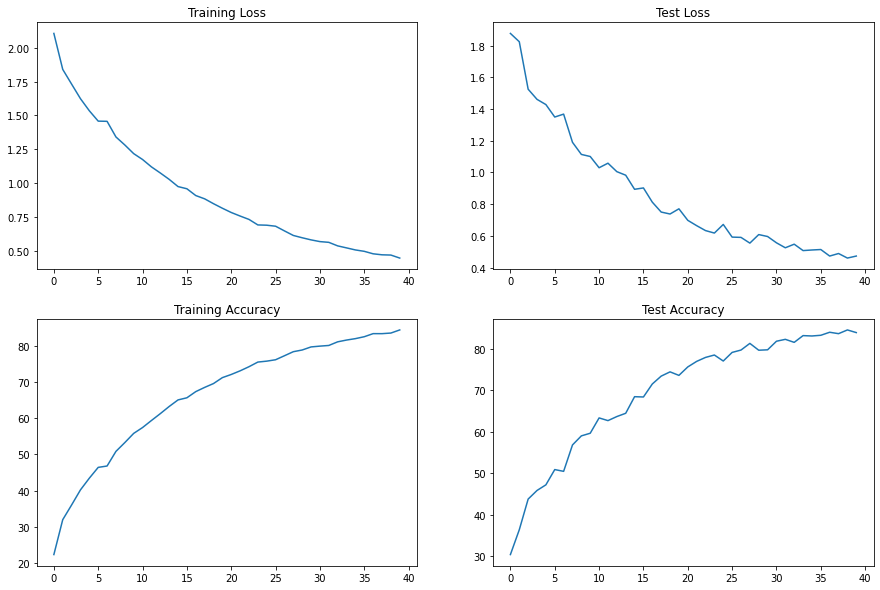

In [ ]:
plotter.plot_loss_acc(ai.metrics['train_loss'], ai.metrics['train_accuracy'], ai.metrics['test_loss'], ai.metrics['test_accuracy'])

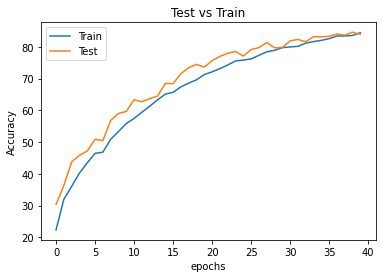

In [ ]:
plotter.plot_combined([ai.metrics['train_accuracy'], ai.metrics['test_accuracy']])

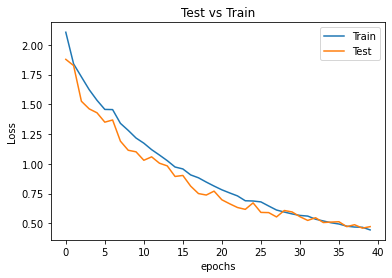

In [ ]:
plotter.plot_combined([ai.metrics['train_loss'], ai.metrics['test_loss']], y_label='Loss')

In [ ]:
from ikshana.visualization import plot_inference, plotter
results = plot_inference.Results(model, test_loader, DEVICE, mean, std, classes)

In [ ]:
results.results['correct_gt'][5]

tensor(0, device='cuda:0')

In [ ]:
results.class_list[results.results['correct_gt'][0]]

'horse'

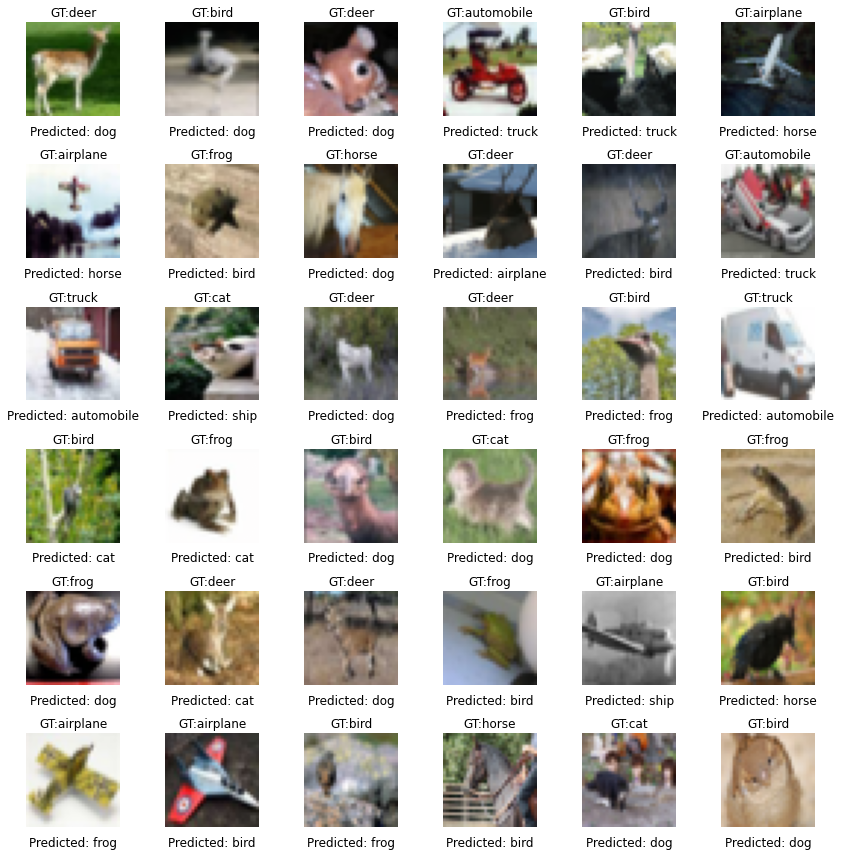

In [ ]:
results.plot_incorrect(ncol=6,nrow=6, figsize=(12,12))

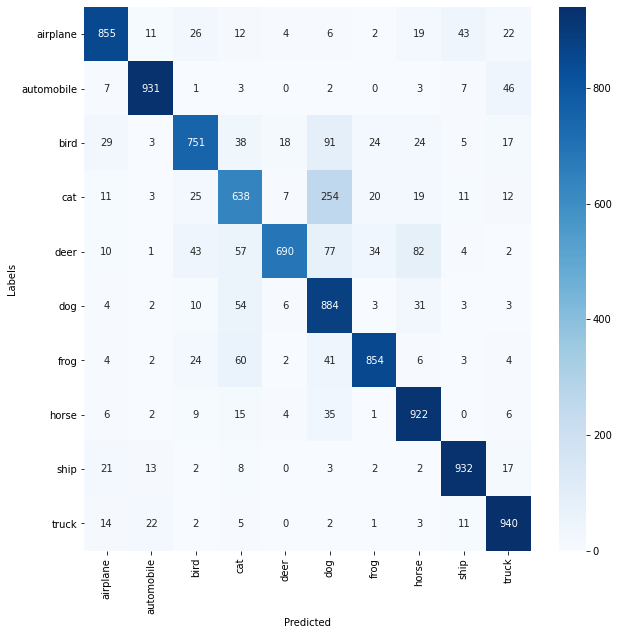

Accuracies of Top 10 Classes in Decreasing Order
Accuracy of class cat is 63.80
Accuracy of class deer is 69.00
Accuracy of class bird is 75.10
Accuracy of class frog is 85.40
Accuracy of class airplane is 85.50
Accuracy of class dog is 88.40
Accuracy of class horse is 92.20
Accuracy of class automobile is 93.10
Accuracy of class ship is 93.20
Accuracy of class truck is 94.00


In [ ]:
results.class_accuracy(figsize=(10,10))

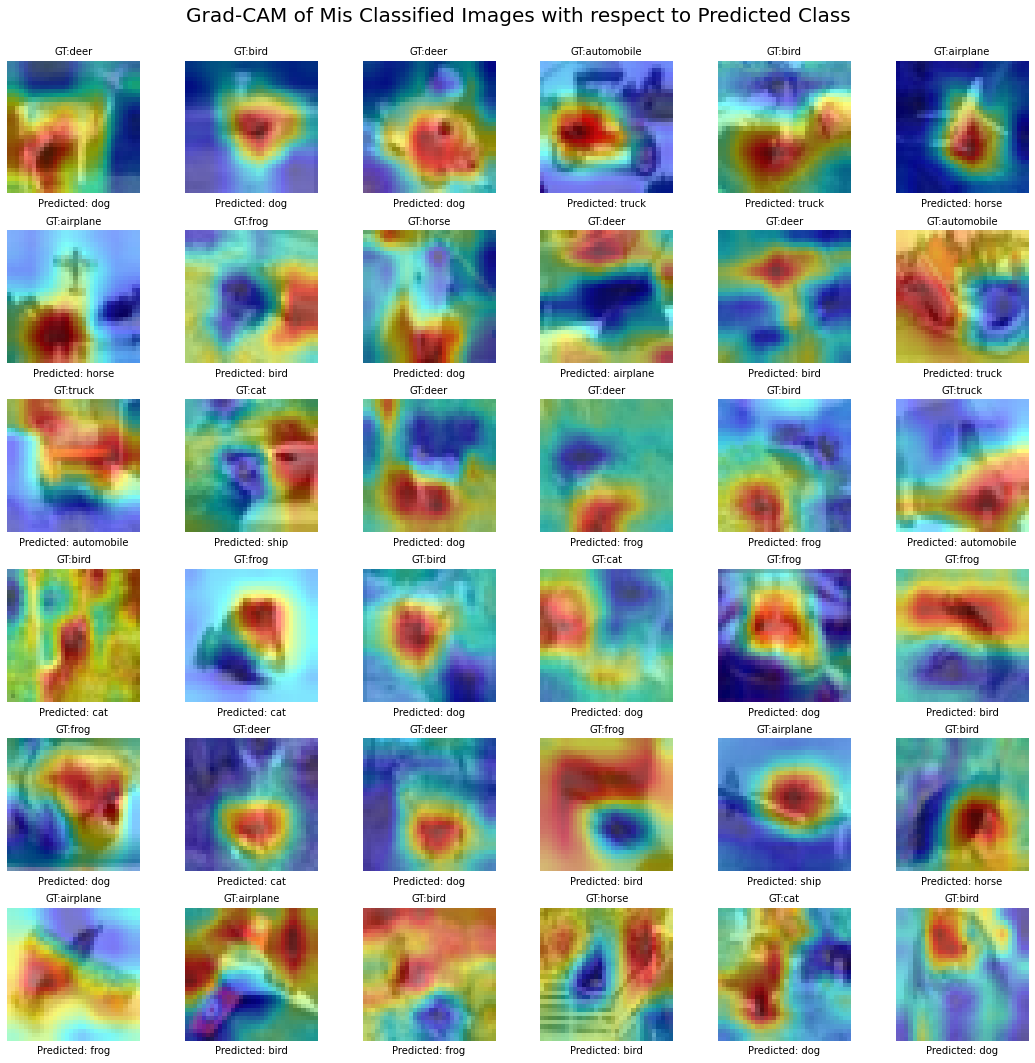

In [ ]:
results.plot_gradcam(correct=False, class_ids=False, hm_lay= 0.5, img_lay= 0.5, alpha= 1.0, ncol=6, nrow=6, figsize= (15,15))

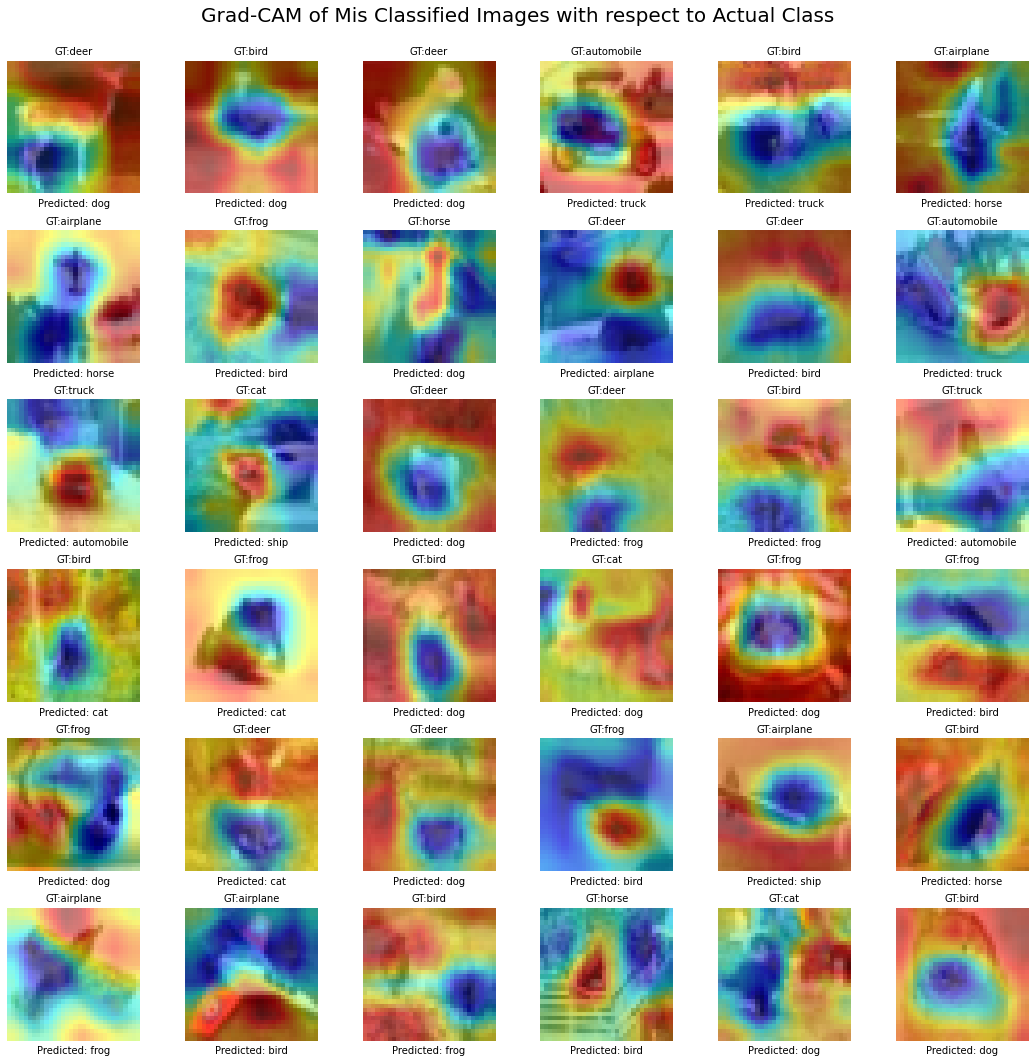

In [ ]:
results.plot_gradcam(correct=False, class_ids=True, hm_lay= 0.5, img_lay= 0.5, alpha= 1.0, ncol=6, nrow=6, figsize= (15,15))

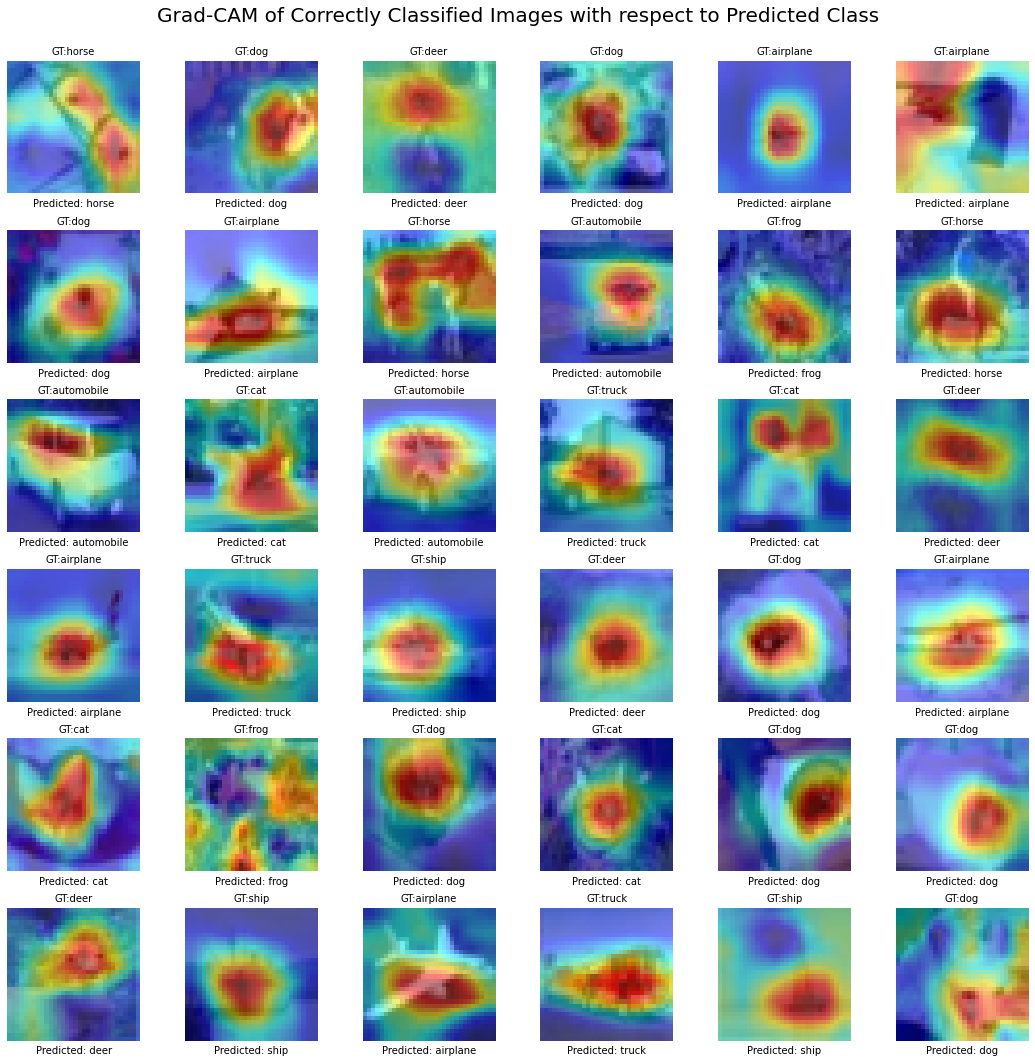

In [ ]:
results.plot_gradcam(correct=True, hm_lay= 0.5, img_lay= 0.5, alpha= 1.0, ncol=6, nrow=6, figsize= (15,15))